In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import random
from pathlib import Path
import logging
from tqdm import tqdm

import pprint
import hdbscan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from capstone.config import CapstoneConfig
from capstone.data_access import DataClass
from capstone.features import Features
from capstone.evaluation import CustomEvaluation
from capstone.utils.constants import (
    TEXT,
    TARGET,
    ORIGINAL_TEXT,
    SPLIT,
    DEVELOP,
    TEST,
    PREDICTION,
    SAVED_MODELS,
    CLUSTER,
    REDUCED_DIMS,
    TARGET_NUMERIC
)

pp = pprint.PrettyPrinter(depth=4)
sns.set_style("darkgrid")
PARENT_PATH = Path(os.getcwd()).parent.absolute()
FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

seed = 666
random.seed(seed)
np.random.seed(seed);

Load data

In [3]:
config = CapstoneConfig()
config.CURRENT_PATH = PARENT_PATH

data = DataClass(config)
df = data.build()
df.head(3)

,Text,Standard mapping?
0,General Quality System Requirements […] Manage...,"[quality management, quality planning]"
1,General Quality System Requirements […] Manage...,[quality management]
2,General Quality System Requirements […] Manage...,[quality management]


In [4]:
features = Features(config)
df_features = features.build(df)

df_features.head(3)

2022-12-15 14:47:06,897 - capstone.utils.utils - INFO - func:clean took: 3.50 sec
2022-12-15 14:47:07,574 - capstone.utils.utils - INFO - func:fit took: 4.17 sec
2022-12-15 14:47:09,565 - capstone.utils.utils - INFO - func:clean took: 1.99 sec
2022-12-15 14:47:09,809 - capstone.utils.utils - INFO - func:transform took: 2.23 sec
2022-12-15 14:47:09,810 - capstone.utils.utils - INFO - func:fit_transform took: 6.41 sec
2022-12-15 14:47:09,999 - capstone.utils.utils - INFO - func:clean took: 0.19 sec
2022-12-15 14:47:10,028 - capstone.utils.utils - INFO - func:transform took: 0.22 sec
2022-12-15 14:47:10,077 - capstone.utils.utils - INFO - func:build took: 6.69 sec


,Text,Standard mapping?,Original Text,audit inspection,calibration,capa,change controls,clinical research,controled substances,csv,...,word__unit generally,word__unit generally shared,word__use device,word__used manufacture,word__used production,word__validation study,word__way ensures,word__wholesale distributor,word__written procedure,Split
0,good practice quality control qc responsibilit...,"[laboratory controls, stability programs]",Good practices in quality control […] Other QC...,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.439675,Development
1,good practice quality control basic requiremen...,"[capa, nc, rca]",Good practices in quality control […] The basi...,0,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,Development
2,validation process validation program critical...,[process & packaging validation],Validation […] Process Validation Program […] ...,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.285952,0.0,0.0,0.000000,Development


In [5]:
# Reduce to test dataset
df_features = df_features[df_features[SPLIT].isin([TEST])]
# Reduce to single-topic regulations
df_features = df_features[df_features[TARGET].apply(lambda x: len(x)) == 1].copy()
df_features.reset_index(drop=True, inplace=True)

In [6]:
# Custom evaluation class
eval = CustomEvaluation()

Topics to choose from for clustering

We want to remove those topics having count less than some threshold

In [7]:
df_features[TARGET].apply(lambda x: x[0]).value_counts()

production process controls                43
clinical research                          27
labeling and packaging operations          25
non clinical research                      18
material and product controls              15
data management                            13
risk management                            13
quality management                         13
purchasing controls                        11
training                                   10
laboratory controls                         9
udi and serialization                       7
stability programs                          7
design controls                             7
audit inspection                            6
samd                                        6
vmp                                         6
medical device post market surveillance     6
vigilance                                   6
controled substances                        6
documentation management                    5
qrb                               

Set the `threshold` and filter out topics having counts less than `threshold`

In [8]:
value_counts = dict(df_features[TARGET].apply(lambda x: x[0]).value_counts())

threshold = 13
keep_topics = {label for label in value_counts if value_counts[label] >= threshold}
print(f"# Topics: {len(keep_topics)}")

for topic in keep_topics:
    assert topic in features.mlb.classes_

def ifkeep(target, keep_topics):
    for y in target:
        if y not in keep_topics:
            return False
    return True

filter = df_features[TARGET].apply(ifkeep, keep_topics=keep_topics)

# Topics: 8


# Evaluate Embeddings

## Model 1. Ada

Get embeddings

In [9]:
EMBEDDINGS = "embeddings"

embeddings_path = os.path.join(data.reports_path, "ada-embeddings.pkl")
embeddings = pd.read_pickle(embeddings_path)

embeddings = pd.DataFrame(embeddings.items(), columns=[ORIGINAL_TEXT, EMBEDDINGS])
embeddings[ORIGINAL_TEXT] = embeddings[ORIGINAL_TEXT].apply(lambda x: x[0])

embeddings = pd.merge(df_features, embeddings, on=ORIGINAL_TEXT)

regulations = embeddings[ORIGINAL_TEXT].values
y_true = np.argmax(embeddings[features.mlb.classes_].to_numpy(), axis=1)
embeddings = np.stack(embeddings[EMBEDDINGS].values)

embeddings.shape

(289, 1024)

#### k-Means (Floyd)

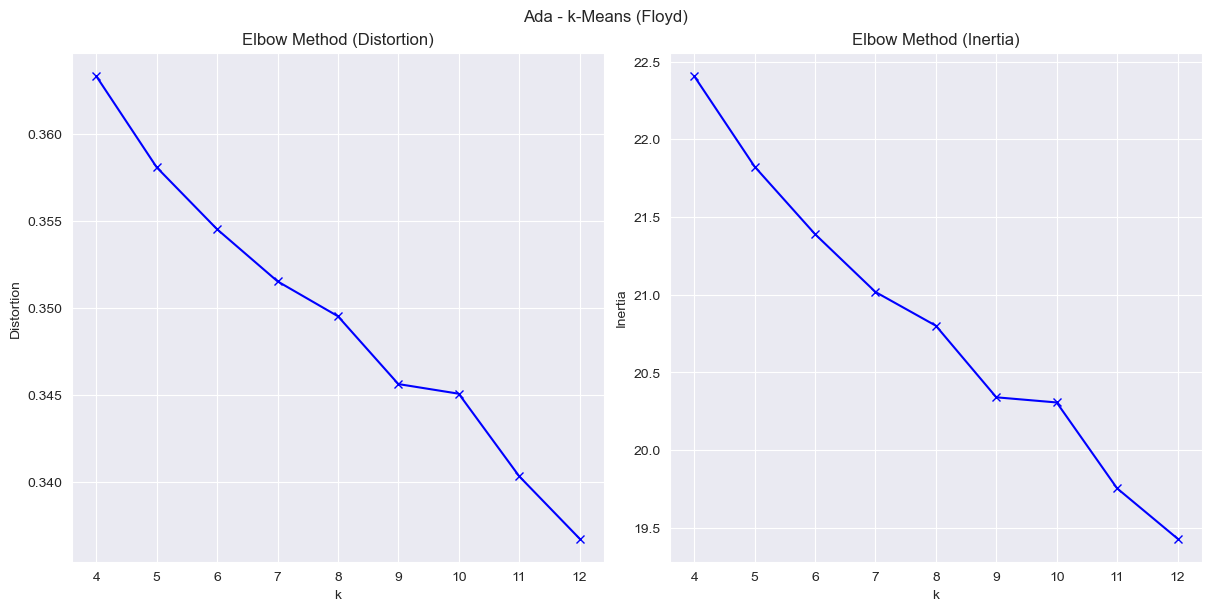

In [10]:
k_values=list(range(len(keep_topics)//2, len(keep_topics)+5))
distortions, inertias = \
    eval.elbow_method(embeddings=embeddings[filter], k_values=k_values)

fig, ax = plt.subplots(1, 2, figsize=(12,6), constrained_layout=True)
ax[0].plot(k_values, distortions, 'bx-')
ax[0].set_xlabel('k')
ax[0].set_ylabel('Distortion')
ax[0].set_title('Elbow Method (Distortion)')
ax[1].plot(k_values, inertias, 'bx-')
ax[1].set_xlabel('k')
ax[1].set_ylabel('Inertia')
ax[1].set_title('Elbow Method (Inertia)')
fig.suptitle("Ada - k-Means (Floyd)");

Purity Scores

In [11]:
k = len(keep_topics)
clusters = KMeans(n_clusters=k, random_state=0).fit(embeddings[filter])

purity_scores, missing, multiple = \
    eval.compute_purity_scores(
        clusters=clusters.labels_,
        y_true=y_true[filter],
        topics=keep_topics,
        features=features
    )
purity_scores

,First Majority,Second Majority,Assigned Cluster
0,"(production process controls, 0.923)","(clinical research, 0.0769)",2
1,"(clinical research, 0.833)","(non clinical research, 0.111)",6
2,"(production process controls, 0.714)","(non clinical research, 0.143)",0
3,"(data management, 0.706)","(risk management, 0.235)",3
4,"(labeling and packaging operations, 0.647)","(material and product controls, 0.235)",4
5,"(clinical research, 0.588)","(non clinical research, 0.412)",5
6,"(production process controls, 0.514)","(material and product controls, 0.2)",7
7,"(quality management, 0.5)","(risk management, 0.269)",1


Check for missing/repeating topics

In [12]:
print("\tMissing:")
if not len(missing):
    print("No missing topics")
else:
    pp.pprint(missing)

print("\n\tMultiple:")
if not len(multiple):
    print("No repeating topics")
else:
    pp.pprint(multiple)

	Missing:
{'non clinical research', 'risk management', 'material and product controls'}

	Multiple:
[('production process controls', 3), ('clinical research', 2)]


Visualize

In [13]:
EMBEDDINGS = [f"llm_{i}" for i in range(embeddings.shape[1])]

embeddings_reduced = \
    TSNE(
        n_components=2, init="random", learning_rate="auto", random_state=0
    ).fit_transform(embeddings[filter])

embeddings_df = pd.DataFrame(embeddings[filter], columns=EMBEDDINGS)
embeddings_df[REDUCED_DIMS] = embeddings_reduced
embeddings_df[CLUSTER] = clusters.labels_
embeddings_df[TARGET] = [features.mlb.classes_[c] for c in y_true[filter]]
embeddings_df[ORIGINAL_TEXT] = regulations[filter]
embeddings_df[ORIGINAL_TEXT] = embeddings_df[ORIGINAL_TEXT].str.wrap(100)
embeddings_df[ORIGINAL_TEXT] = embeddings_df[ORIGINAL_TEXT].str.replace("\n", "<br>")

fig = px.scatter(
    embeddings_df,
    y=REDUCED_DIMS[1],
    x=REDUCED_DIMS[0],
    color=CLUSTER,
    symbol=TARGET,
    hover_data=[ORIGINAL_TEXT, TARGET],
    title="Ada with K-Means and TSNE"
)
fig.update_layout(uniformtext_mode="hide")
fig.update_layout(legend_orientation="h")
fig.show()

#### Hierarchical Clustering

Purity Scores

In [14]:
clusters = \
    hdbscan.HDBSCAN(
        min_cluster_size=2,
        metric="euclidean",
        cluster_selection_method="eom"
    ).fit(embeddings[filter])

purity_scores, missing, multiple = \
    eval.compute_purity_scores(
        clusters=clusters.labels_,
        y_true=y_true[filter],
        topics=keep_topics,
        features=features
    )
purity_scores

,First Majority,Second Majority,Assigned Cluster
0,"(clinical research, 1.0)","(-1, 0.0)",0
1,"(data management, 1.0)","(-1, 0.0)",1
2,"(clinical research, 1.0)","(-1, 0.0)",2
3,"(non clinical research, 1.0)","(-1, 0.0)",3
4,"(labeling and packaging operations, 0.38)","(production process controls, 0.34)",4


Check for missing/repeating topics

In [15]:
print("\tMissing:")
if not len(missing):
    print("No missing topics")
else:
    pp.pprint(missing)

print("\n\tMultiple:")
if not len(multiple):
    print("No repeating topics")
else:
    pp.pprint(multiple)

num_unclustered = sum(clusters.labels_==-1) / clusters.labels_.shape[0]
print(f"\nUnclustered samples: {num_unclustered*100:.3}%")

	Missing:
{'material and product controls',
 'production process controls',
 'quality management',
 'risk management'}

	Multiple:
[('clinical research', 2)]

Unclustered samples: 64.1%


Visualize

In [16]:
embeddings_df[CLUSTER] = clusters.labels_

fig = px.scatter(
    embeddings_df,
    y=REDUCED_DIMS[1],
    x=REDUCED_DIMS[0],
    color=CLUSTER,
    symbol=TARGET,
    hover_data=[ORIGINAL_TEXT, TARGET],
    title="Ada - HDBSCAN and TSNE"
)
fig.update_layout(uniformtext_mode="hide")
fig.update_layout(legend_orientation="h")
fig.show()

## Model 2. Curie

Get embeddings

In [17]:
EMBEDDINGS = "embeddings"

embeddings_path = os.path.join(data.reports_path, "curie-embeddings.pkl")
embeddings = pd.read_pickle(embeddings_path)

embeddings = pd.DataFrame(embeddings.items(), columns=[ORIGINAL_TEXT, EMBEDDINGS])
embeddings[ORIGINAL_TEXT] = embeddings[ORIGINAL_TEXT].apply(lambda x: x[0])

embeddings = pd.merge(df_features, embeddings, on=ORIGINAL_TEXT)

regulations = embeddings[ORIGINAL_TEXT].values
y_true = np.argmax(embeddings[features.mlb.classes_].to_numpy(), axis=1)
embeddings = np.stack(embeddings[EMBEDDINGS].values)

embeddings.shape

(289, 4096)

#### k-Means (Floyd)

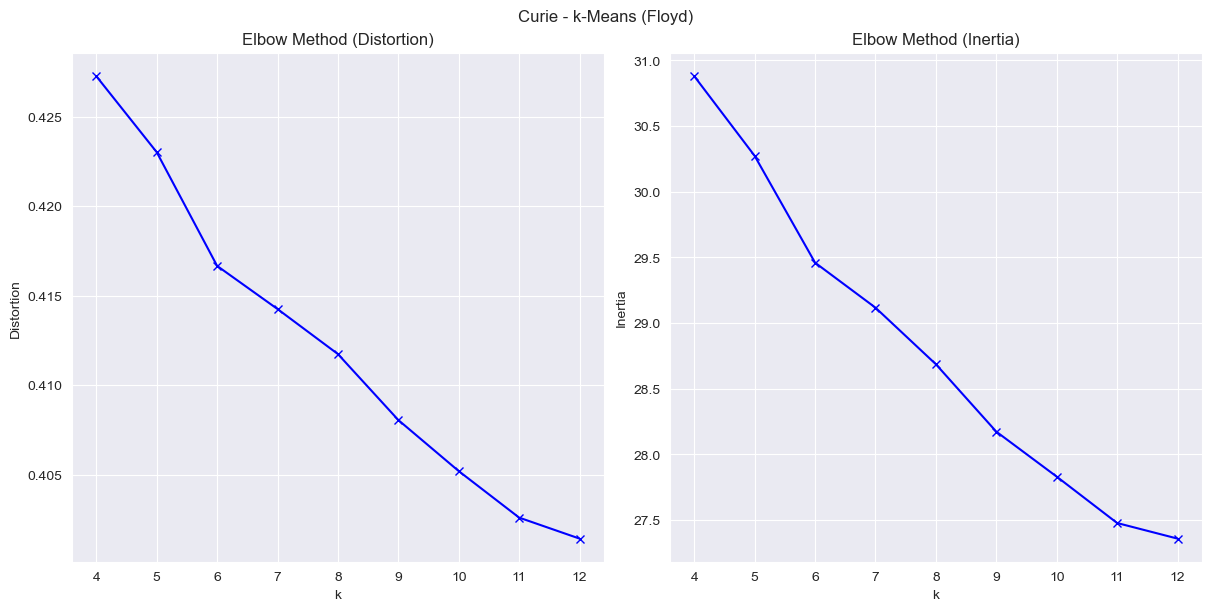

In [18]:
k_values=list(range(len(keep_topics)//2, len(keep_topics)+5))
distortions, inertias = \
    eval.elbow_method(embeddings=embeddings[filter], k_values=k_values)

fig, ax = plt.subplots(1, 2, figsize=(12,6), constrained_layout=True)
ax[0].plot(k_values, distortions, 'bx-')
ax[0].set_xlabel('k')
ax[0].set_ylabel('Distortion')
ax[0].set_title('Elbow Method (Distortion)')
ax[1].plot(k_values, inertias, 'bx-')
ax[1].set_xlabel('k')
ax[1].set_ylabel('Inertia')
ax[1].set_title('Elbow Method (Inertia)')
fig.suptitle("Curie - k-Means (Floyd)");

Purity Scores

In [19]:
k = len(keep_topics)
clusters = KMeans(n_clusters=k, random_state=0).fit(embeddings[filter])

purity_scores, missing, multiple = \
    eval.compute_purity_scores(
        clusters=clusters.labels_,
        y_true=y_true[filter],
        topics=keep_topics,
        features=features
    )
purity_scores

,First Majority,Second Majority,Assigned Cluster
0,"(risk management, 1.0)","(-1, 0.0)",3
1,"(clinical research, 0.812)","(risk management, 0.188)",4
2,"(production process controls, 0.615)","(clinical research, 0.0769)",2
3,"(non clinical research, 0.5)","(production process controls, 0.333)",6
4,"(production process controls, 0.471)","(material and product controls, 0.235)",7
5,"(data management, 0.417)","(risk management, 0.333)",0
6,"(labeling and packaging operations, 0.404)","(production process controls, 0.298)",1
7,"(clinical research, 0.391)","(non clinical research, 0.391)",5


Check for missing/repeating topics

In [20]:
print("\tMissing:")
if not len(missing):
    print("No missing topics")
else:
    pp.pprint(missing)

print("\n\tMultiple:")
if not len(multiple):
    print("No repeating topics")
else:
    pp.pprint(multiple)

	Missing:
{'quality management', 'material and product controls'}

	Multiple:
[('production process controls', 2), ('clinical research', 2)]


Visualize

In [21]:
EMBEDDINGS = [f"llm_{i}" for i in range(embeddings.shape[1])]

embeddings_reduced = \
    TSNE(
        n_components=2, init="random", learning_rate="auto", random_state=0
    ).fit_transform(embeddings[filter])

embeddings_df = pd.DataFrame(embeddings[filter], columns=EMBEDDINGS)
embeddings_df[REDUCED_DIMS] = embeddings_reduced
embeddings_df[CLUSTER] = clusters.labels_
embeddings_df[TARGET] = [features.mlb.classes_[c] for c in y_true[filter]]
embeddings_df[ORIGINAL_TEXT] = regulations[filter]
embeddings_df[ORIGINAL_TEXT] = embeddings_df[ORIGINAL_TEXT].str.wrap(100)
embeddings_df[ORIGINAL_TEXT] = embeddings_df[ORIGINAL_TEXT].str.replace("\n", "<br>")

fig = px.scatter(
    embeddings_df,
    y=REDUCED_DIMS[1],
    x=REDUCED_DIMS[0],
    color=CLUSTER,
    symbol=TARGET,
    hover_data=[ORIGINAL_TEXT, TARGET],
    title="Curie with k-means and TSNE"
)
fig.update_layout(uniformtext_mode="hide")
fig.update_layout(legend_orientation="h")
fig.show()

#### Hierarchical Clustering

Purity Scores

In [22]:
clusters = \
    hdbscan.HDBSCAN(
        min_cluster_size=2,
        metric="euclidean",
        cluster_selection_method="eom"
    ).fit(embeddings[filter])

purity_scores, missing, multiple = \
    eval.compute_purity_scores(
        clusters=clusters.labels_,
        y_true=y_true[filter],
        topics=keep_topics,
        features=features
    )
purity_scores

,First Majority,Second Majority,Assigned Cluster
0,"(risk management, 0.75)","(quality management, 0.25)",1
1,"(production process controls, 0.257)","(labeling and packaging operations, 0.21)",0


Check for missing/repeating topics

In [23]:
print("\tMissing:")
if not len(missing):
    print("No missing topics")
else:
    pp.pprint(missing)

print("\n\tMultiple:")
if not len(multiple):
    print("No repeating topics")
else:
    pp.pprint(multiple)

num_unclustered = sum(clusters.labels_==-1) / clusters.labels_.shape[0]
print(f"\nUnclustered samples: {num_unclustered*100:.3}%")

	Missing:
{'clinical research',
 'data management',
 'labeling and packaging operations',
 'material and product controls',
 'non clinical research',
 'quality management'}

	Multiple:
No repeating topics

Unclustered samples: 34.7%


Visualize

In [24]:
embeddings_df[CLUSTER] = clusters.labels_

fig = px.scatter(
    embeddings_df,
    y=REDUCED_DIMS[1],
    x=REDUCED_DIMS[0],
    color=CLUSTER,
    symbol=TARGET,
    hover_data=[ORIGINAL_TEXT, TARGET],
    title="Curie - HDBSCAN with TSNE"
)
fig.update_layout(uniformtext_mode="hide")
fig.update_layout(legend_orientation="h")
fig.show()

## Model 3. Davinci

Get embeddings

In [25]:
EMBEDDINGS = "embeddings"

embeddings_path = os.path.join(data.reports_path, "davinci-embeddings.pkl")
embeddings = pd.read_pickle(embeddings_path)

embeddings = pd.DataFrame(embeddings.items(), columns=[ORIGINAL_TEXT, EMBEDDINGS])
embeddings[ORIGINAL_TEXT] = embeddings[ORIGINAL_TEXT].apply(lambda x: x[0])

embeddings = pd.merge(df_features, embeddings, on=ORIGINAL_TEXT)

regulations = embeddings[ORIGINAL_TEXT].values
y_true = np.argmax(embeddings[features.mlb.classes_].to_numpy(), axis=1)
embeddings = np.stack(embeddings[EMBEDDINGS].values)

embeddings.shape

(289, 12288)

#### k-Means (Floyd)

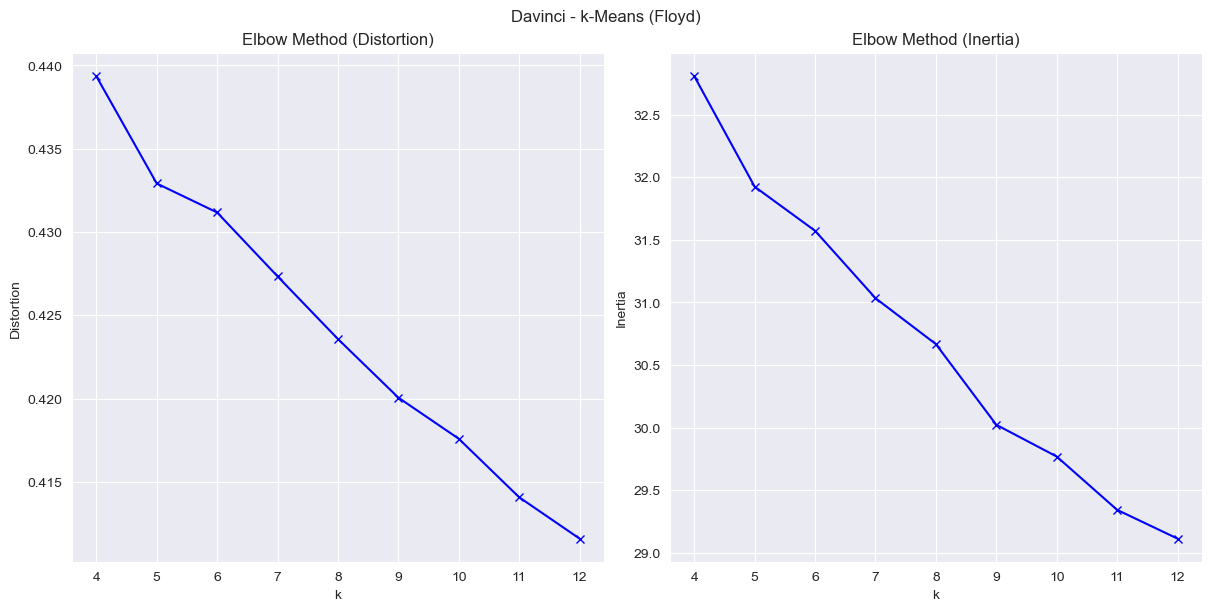

In [26]:
k_values=list(range(len(keep_topics)//2, len(keep_topics)+5))
distortions, inertias = \
    eval.elbow_method(embeddings=embeddings[filter], k_values=k_values)

fig, ax = plt.subplots(1, 2, figsize=(12,6), constrained_layout=True)
ax[0].plot(k_values, distortions, 'bx-')
ax[0].set_xlabel('k')
ax[0].set_ylabel('Distortion')
ax[0].set_title('Elbow Method (Distortion)')
ax[1].plot(k_values, inertias, 'bx-')
ax[1].set_xlabel('k')
ax[1].set_ylabel('Inertia')
ax[1].set_title('Elbow Method (Inertia)')
fig.suptitle("Davinci - k-Means (Floyd)");

Purity Scores

In [27]:
k = len(keep_topics)
clusters = KMeans(n_clusters=k, random_state=0).fit(embeddings[filter])

purity_scores, missing, multiple = \
    eval.compute_purity_scores(
        clusters=clusters.labels_,
        y_true=y_true[filter],
        topics=keep_topics,
        features=features
    )
purity_scores

,First Majority,Second Majority,Assigned Cluster
0,"(data management, 1.0)","(-1, 0.0)",7
1,"(clinical research, 0.923)","(risk management, 0.0769)",0
2,"(production process controls, 0.542)","(material and product controls, 0.167)",1
3,"(quality management, 0.5)","(data management, 0.2)",5
4,"(non clinical research, 0.484)","(clinical research, 0.323)",3
5,"(production process controls, 0.451)","(labeling and packaging operations, 0.314)",6
6,"(production process controls, 0.385)","(risk management, 0.308)",2
7,"(clinical research, 0.214)","(data management, 0.214)",4


Check for missing/repeating topics

In [28]:
print("\tMissing:")
if not len(missing):
    print("No missing topics")
else:
    pp.pprint(missing)

print("\n\tMultiple:")
if not len(multiple):
    print("No repeating topics")
else:
    pp.pprint(multiple)

	Missing:
{'labeling and packaging operations',
 'material and product controls',
 'risk management'}

	Multiple:
[('clinical research', 2), ('production process controls', 3)]


Visualize

In [29]:
EMBEDDINGS = [f"llm_{i}" for i in range(embeddings.shape[1])]

embeddings_reduced = \
    TSNE(
        n_components=2, init="random", learning_rate="auto", random_state=0
    ).fit_transform(embeddings[filter])

embeddings_df = pd.DataFrame(embeddings[filter], columns=EMBEDDINGS)
embeddings_df[REDUCED_DIMS] = embeddings_reduced
embeddings_df[CLUSTER] = clusters.labels_
embeddings_df[TARGET] = [features.mlb.classes_[c] for c in y_true[filter]]
embeddings_df[ORIGINAL_TEXT] = regulations[filter]
embeddings_df[ORIGINAL_TEXT] = embeddings_df[ORIGINAL_TEXT].str.wrap(100)
embeddings_df[ORIGINAL_TEXT] = embeddings_df[ORIGINAL_TEXT].str.replace("\n", "<br>")

fig = px.scatter(
    embeddings_df,
    y=REDUCED_DIMS[1],
    x=REDUCED_DIMS[0],
    color=CLUSTER,
    symbol=TARGET,
    hover_data=[ORIGINAL_TEXT, TARGET],
    title="Davinci with k-means and TSNE"
)
fig.update_layout(uniformtext_mode="hide")
fig.update_layout(legend_orientation="h")
fig.show()

#### Hierarchical Clustering

Purity Scores

In [30]:
clusters = \
    hdbscan.HDBSCAN(
        min_cluster_size=2,
        metric="euclidean",
        cluster_selection_method="eom"
    ).fit(embeddings[filter])

purity_scores, missing, multiple = \
    eval.compute_purity_scores(
        clusters=clusters.labels_,
        y_true=y_true[filter],
        topics=keep_topics,
        features=features
    )
purity_scores

,First Majority,Second Majority,Assigned Cluster
0,"(clinical research, 1.0)","(-1, 0.0)",1
1,"(clinical research, 1.0)","(-1, 0.0)",2
2,"(production process controls, 0.312)","(labeling and packaging operations, 0.194)",0


Check for missing/repeating topics

In [31]:
print("\tMissing:")
if not len(missing):
    print("No missing topics")
else:
    pp.pprint(missing)

print("\n\tMultiple:")
if not len(multiple):
    print("No repeating topics")
else:
    pp.pprint(multiple)

num_unclustered = sum(clusters.labels_==-1) / clusters.labels_.shape[0]
print(f"\nUnclustered samples: {num_unclustered*100:.3}%")

	Missing:
{'data management',
 'labeling and packaging operations',
 'material and product controls',
 'non clinical research',
 'quality management',
 'risk management'}

	Multiple:
[('clinical research', 2)]

Unclustered samples: 41.3%


Visualize

In [32]:
embeddings_df[CLUSTER] = clusters.labels_

fig = px.scatter(
    embeddings_df,
    y=REDUCED_DIMS[1],
    x=REDUCED_DIMS[0],
    color=CLUSTER,
    symbol=TARGET,
    hover_data=[ORIGINAL_TEXT, TARGET],
    title="Davinci - HDBSCAN with TSNE"
)
fig.update_layout(uniformtext_mode="hide")
fig.update_layout(legend_orientation="h")
fig.show()